In [3]:
%cd ~\ZZSC9020_Project\Group10_project

import os
import shutil
import numpy as np
import pandas as pd
import pmdarima as pmd
from datetime import datetime as dt
import statsmodels.tsa as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

c:\Users\KJR\anaconda3\envs\zzsc9020_project\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
c:\Users\KJR\anaconda3\envs\zzsc9020_project\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\KJR\ZZSC9020_Project\Group10_project


In [4]:
PATH = os.getcwd()+"/data/SILO/"

QLD_DATA = pd.read_csv(PATH+"QLD_new_Rolling_Data.csv",header=0)
NSW_DATA = pd.read_csv(PATH+"NSW_Rolling_Data.csv",header=0)

In [5]:
QLD_Forecasting_supplementary = pd.read_csv(PATH+"totaldemand_qld.csv",header=0)
QLD_Forecasting_supplementary['DATETIME'] = pd.to_datetime(QLD_Forecasting_supplementary['DATETIME'])
#QLD_Forecasting_supplementary = QLD_Forecasting_supplementary[QLD_Forecasting_supplementary['DATETIME'].dt.year > 2016]
QLD_Forecasting_supplementary = QLD_Forecasting_supplementary.groupby(by=pd.Grouper(freq='6H',key='DATETIME')).max()
QLD_Forecasting_supplementary

C:\Users\KJR\AppData\Local\Temp\ipykernel_29976\1345909658.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  QLD_Forecasting_supplementary = QLD_Forecasting_supplementary.groupby(by=pd.Grouper(freq='6H',key='DATETIME')).max()


,TOTALDEMAND,REGIONID
DATETIME,,
2010-01-01 00:00:00,5561.21,QLD1
2010-01-01 06:00:00,6259.79,QLD1
2010-01-01 12:00:00,6349.81,QLD1
2010-01-01 18:00:00,6377.41,QLD1
2010-01-02 00:00:00,5447.35,QLD1
...,...,...
2021-03-17 00:00:00,5764.92,QLD1
2021-03-17 06:00:00,6828.90,QLD1
2021-03-17 12:00:00,7261.41,QLD1


In [204]:
qld_temp_supplementary = pd.read_csv(PATH+'temperature_qld.csv',header=0)
qld_temp_supplementary['DATETIME'] = pd.to_datetime(qld_temp_supplementary['DATETIME'], format='mixed', dayfirst=True)
qld_temp_supplementary.drop('LOCATION',axis=1,inplace=True)
qld_temp_supplementary = qld_temp_supplementary.groupby(by=pd.Grouper(freq='6H',key='DATETIME')).mean()
qld_temp_supplementary

C:\Users\KJR\AppData\Local\Temp\ipykernel_3904\1462725305.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  qld_temp_supplementary = qld_temp_supplementary.groupby(by=pd.Grouper(freq='6H',key='DATETIME')).mean()


,TEMPERATURE
DATETIME,
2010-01-01 00:00:00,22.216667
2010-01-01 06:00:00,26.591667
2010-01-01 12:00:00,27.341667
2010-01-01 18:00:00,24.100000
2010-01-02 00:00:00,23.400000
...,...
2021-03-17 00:00:00,18.733333
2021-03-17 06:00:00,19.600000
2021-03-17 12:00:00,20.556250


In [6]:
QLD_DATA['DATETIME'] = pd.to_datetime(QLD_DATA['DATETIME'])
QLD_DATA.index = QLD_DATA['DATETIME']
QLD_DATA.drop('DATETIME',axis=1,inplace=True)


In [162]:
QLD['TOTALDEMAND'] = QLD_Forecasting_supplementary['TOTALDEMAND']
QLD['TEMPERATURE'] = qld_temp_supplementary['TEMPERATURE']

In [71]:
BASELINE = pd.read_csv(PATH+"forecastdemand_qld.csv",header=0)
BASELINE = BASELINE[BASELINE['PERIODID'] == 1]
BASELINE.drop(['PREDISPATCHSEQNO', 'REGIONID', 'PERIODID', 'LASTCHANGED'],axis=1,inplace=True)
BASELINE['DATETIME'] = pd.to_datetime(BASELINE['DATETIME'])
BASELINE = BASELINE.groupby(by=pd.Grouper(freq='D', key='DATETIME')).max()
base_prediction = BASELINE['FORECASTDEMAND']
base_prediction.head(5)


DATETIME
2017-01-01    8094.01
2017-01-02    7992.85
2017-01-03    7364.11
2017-01-04    7431.58
2017-01-05    7615.26
Freq: D, Name: FORECASTDEMAND, dtype: float64

In [7]:
QLD_DATA.drop(['high_humid_change', 'high_temp_change', 'high_rain_change'],axis=1,inplace=True)
#QLD_DATA = QLD_DATA.loc[QLD_DATA.index.year > 2016]
QLD_DATA

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,humid_change,rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
DATETIME,,,,,,,,,,,,,,,
2010-01-01,5760.08,25.02,0.0,6.4,20.3,23.1,69.75,0.0,0.0,0.00,0.00,0.0,0,0,0
2010-01-02,5965.03,26.35,0.2,7.4,24.6,23.8,70.15,0.0,0.0,1.33,0.40,0.2,0,0,0
2010-01-03,6026.73,25.46,0.0,4.2,13.1,27.6,78.25,0.0,0.0,-0.89,8.10,-0.2,0,0,0
2010-01-04,6305.92,24.60,10.4,4.0,11.3,23.2,72.10,1.0,0.0,-0.86,-6.15,10.4,0,0,0
2010-01-05,6266.62,23.87,0.0,4.8,15.5,22.4,75.00,0.0,0.0,-0.73,2.90,-10.4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,6351.05,25.19,0.0,6.1,24.2,24.6,80.55,1.0,0.0,1.27,3.15,0.0,1,1,1
2021-03-15,6798.86,21.27,2.6,2.3,4.8,23.8,84.00,1.0,0.0,-3.92,3.45,2.6,0,1,1
2021-03-16,6472.06,20.39,6.8,2.1,8.3,18.8,72.65,1.0,0.0,-0.88,-11.35,4.2,0,1,1


In [9]:
QLD_DATA['TEMPERATURE'] = QLD_DATA['TEMPERATURE'].fillna(QLD_DATA['TEMPERATURE'].mean())
QLD_DATA['temp_change'] = QLD_DATA['temp_change'].fillna(0)
QLD_DATA['TEMPERATURE'].isna().value_counts()

TEMPERATURE
False    4095
Name: count, dtype: int64

In [10]:
QLD = QLD_DATA.drop(['Evap','bushfire','flood', 'temp_change'],axis=1)
QLD_CLIMATE_ONLY = QLD_DATA.drop(['Evap','bushfire', 'flood', 'temp_change', 'humid_change', 'rain_change', 'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],axis=1)


In [11]:
train = QLD[:-28]
test = QLD[-28:]
print(train.head())
print(test.head())

y_train = train['TOTALDEMAND']
y_test = test['TOTALDEMAND']

            TOTALDEMAND  TEMPERATURE  Rain  Radn    VP     RH  humid_change  \
DATETIME                                                                      
2010-01-01      5760.08        25.02   0.0  20.3  23.1  69.75          0.00   
2010-01-02      5965.03        26.35   0.2  24.6  23.8  70.15          0.40   
2010-01-03      6026.73        25.46   0.0  13.1  27.6  78.25          8.10   
2010-01-04      6305.92        24.60  10.4  11.3  23.2  72.10         -6.15   
2010-01-05      6266.62        23.87   0.0  15.5  22.4  75.00          2.90   

            rain_change  high_humid_past_week  high_rain_past_week  \
DATETIME                                                             
2010-01-01          0.0                     0                    0   
2010-01-02          0.2                     0                    0   
2010-01-03         -0.2                     0                    0   
2010-01-04         10.4                     0                    0   
2010-01-05        -10.4   

In [12]:
print ("\nMissing values :  ", QLD_DATA.isnull().any())


Missing values :   TOTALDEMAND             False
TEMPERATURE             False
Rain                    False
Evap                    False
Radn                    False
VP                      False
RH                      False
bushfire                False
flood                   False
temp_change             False
humid_change            False
rain_change             False
high_humid_past_week    False
high_rain_past_week     False
high_temp_past_week     False
dtype: bool


In [314]:
ts_decomposition = seasonal_decompose(x=train['TOTALDEMAND'], model='multiplicative', period=4)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

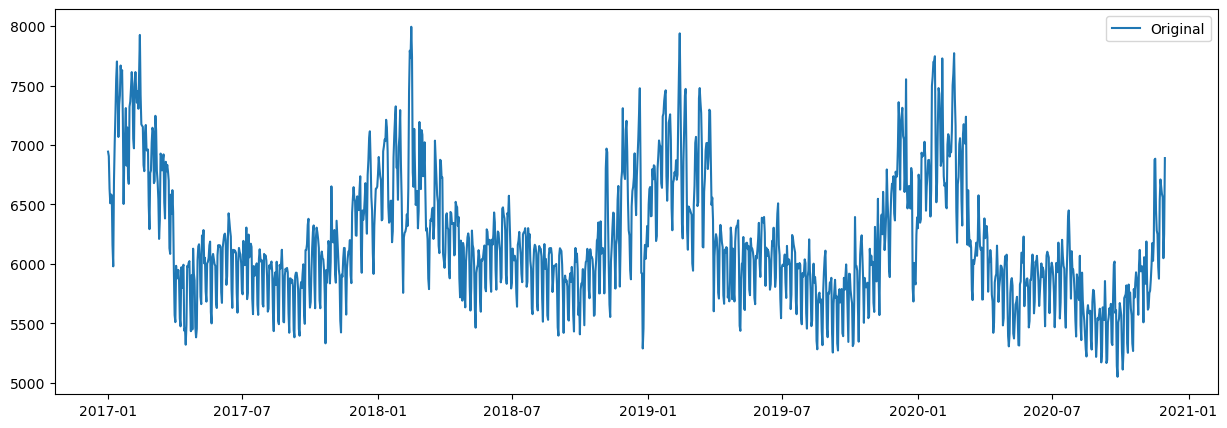

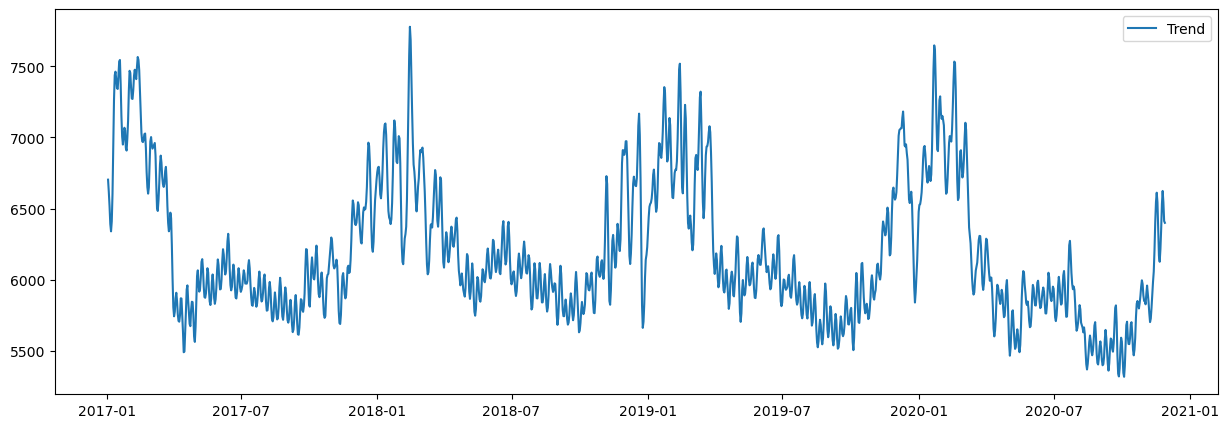

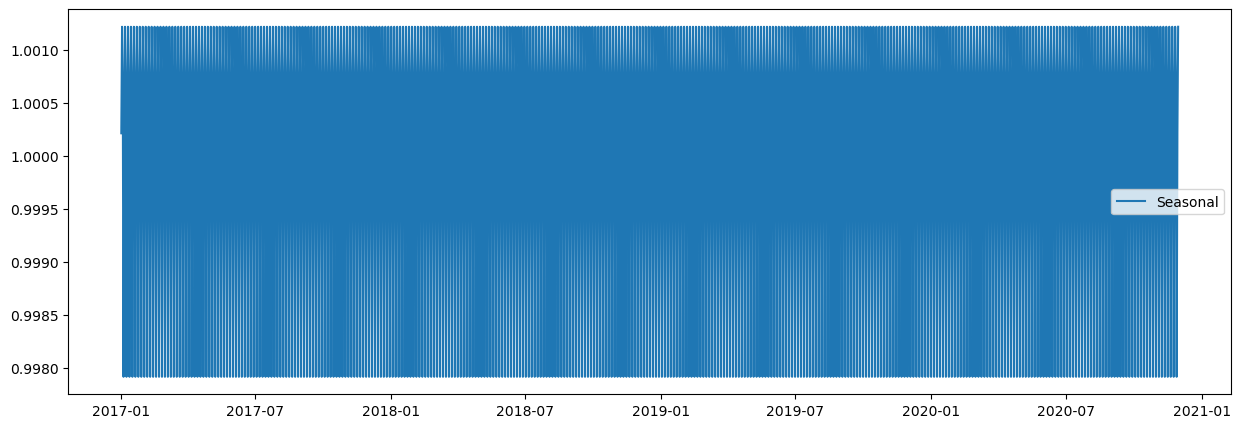

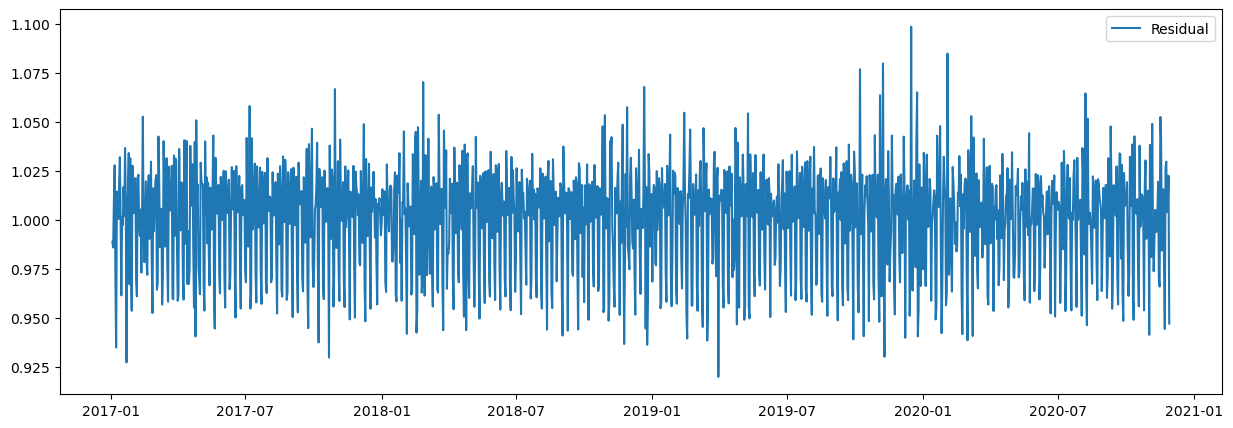

In [237]:
plt.figure(figsize=(15,5))
plt.plot(y_train, label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

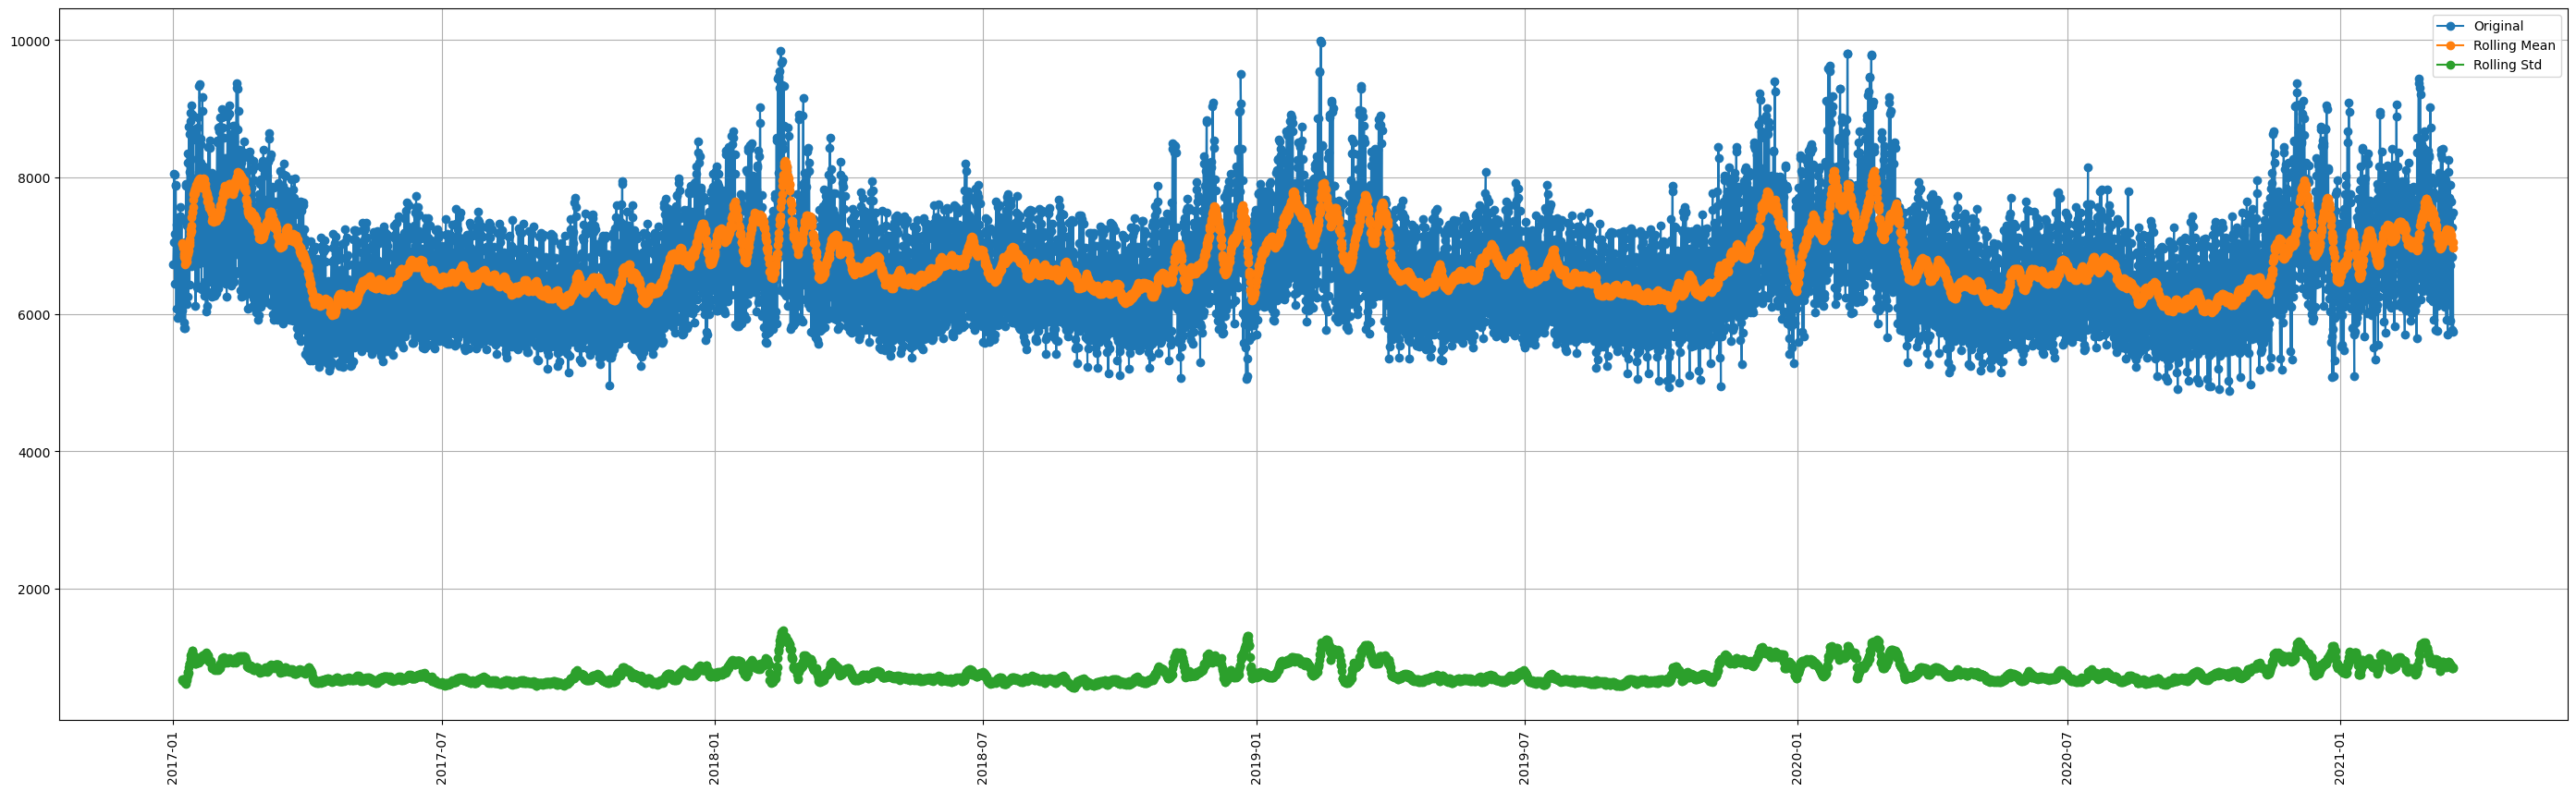

In [222]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(QLD.index, QLD['TOTALDEMAND'], marker='o', label='Original')
plt.plot(QLD.index, QLD['TOTALDEMAND'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(QLD.index, QLD['TOTALDEMAND'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

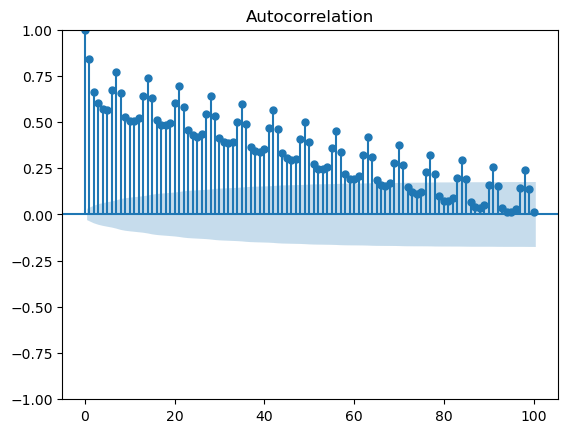

In [180]:
plot_acf(QLD_DATA['TOTALDEMAND'], lags=100)
plt.show()

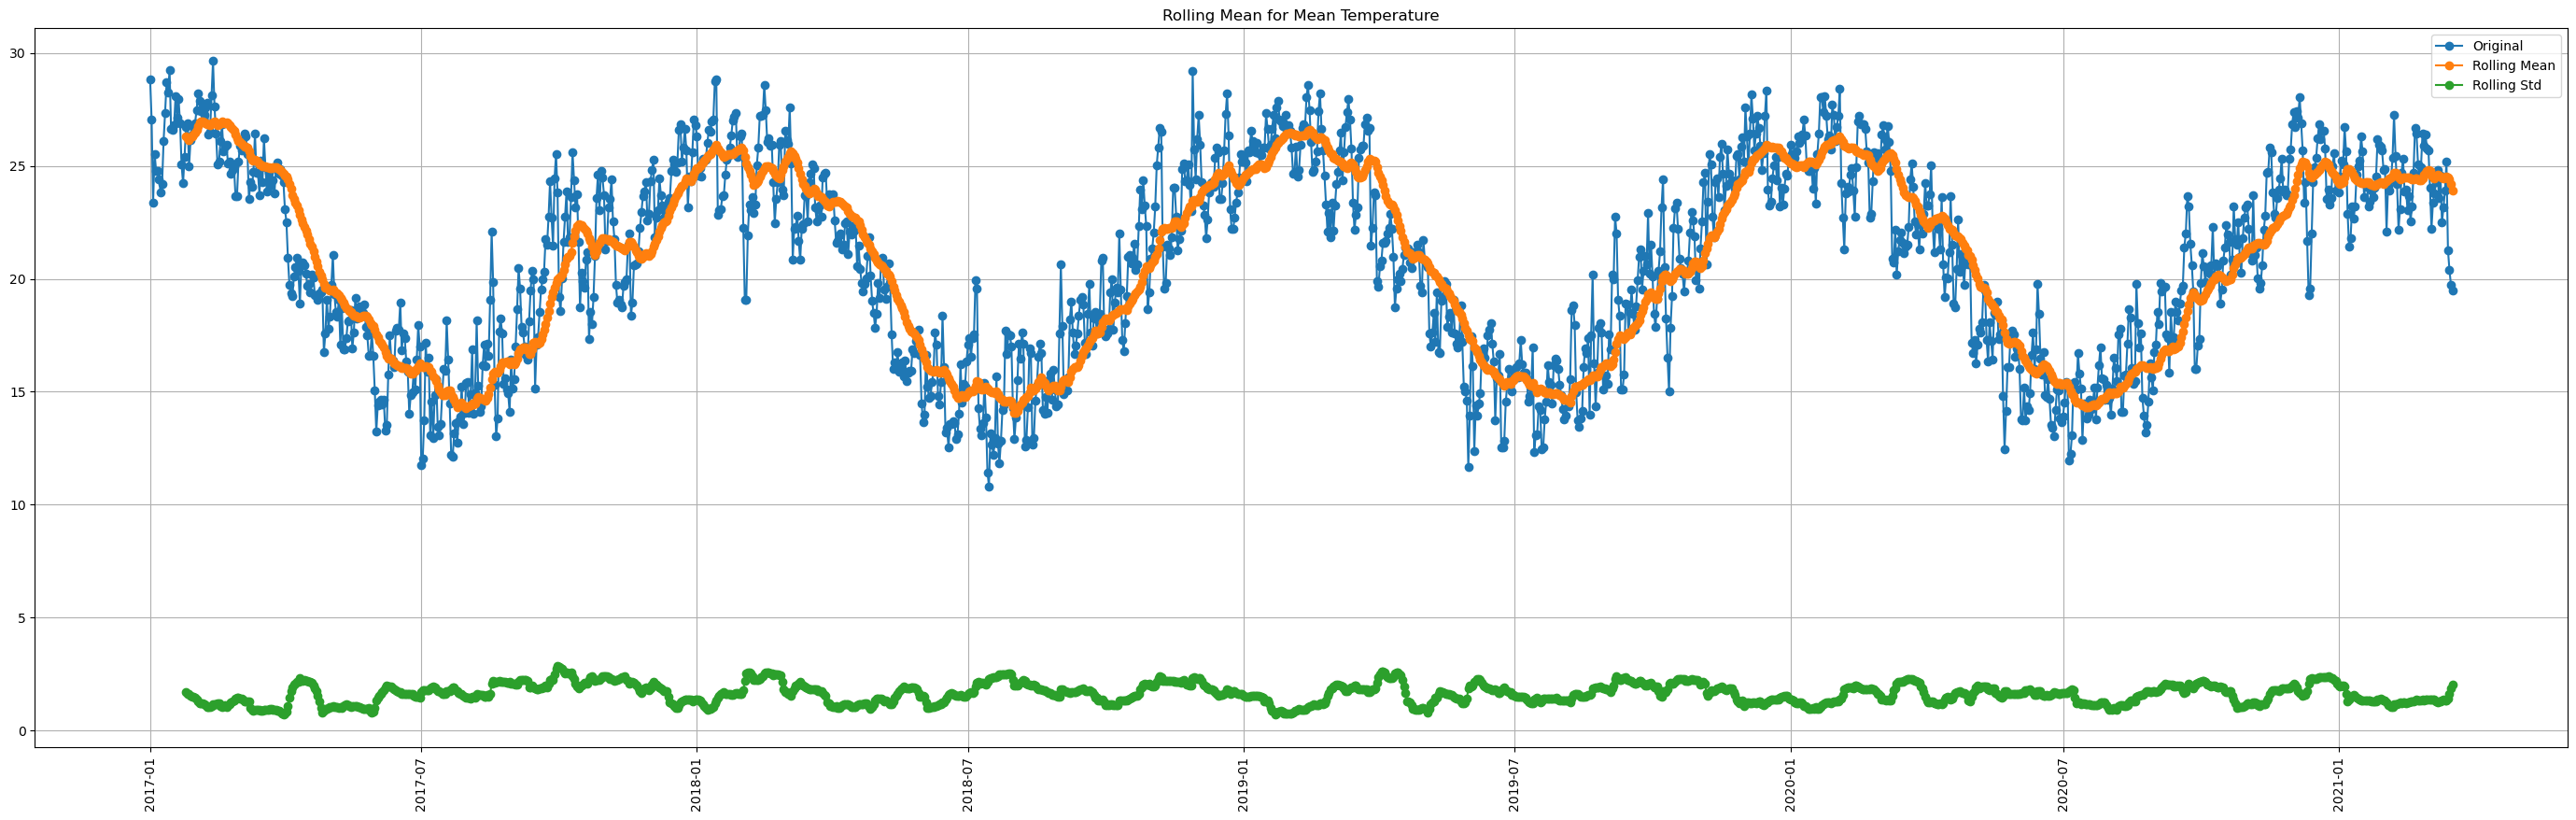

In [82]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['TEMPERATURE'], marker='o', label='Original')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['TEMPERATURE'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['TEMPERATURE'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Mean Temperature")
plt.legend()
plt.show()

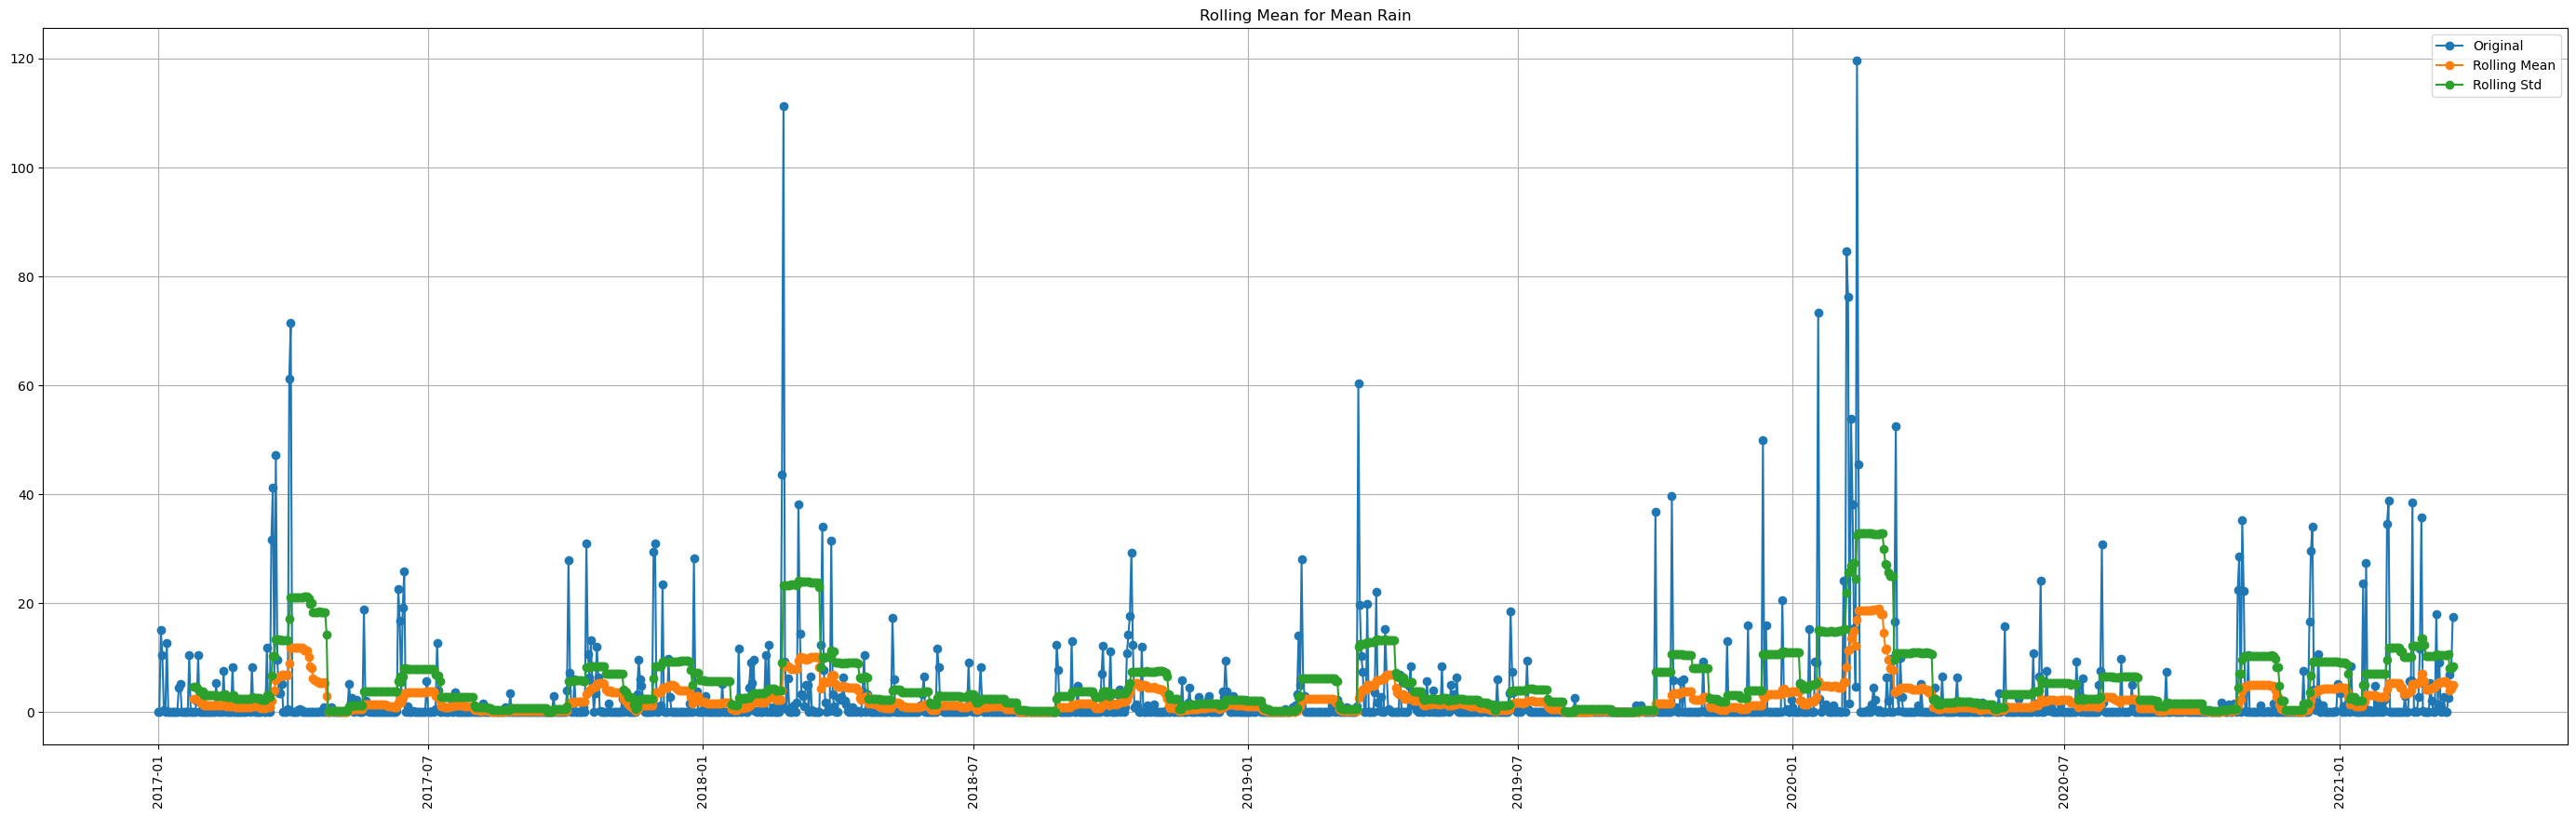

In [33]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['Rain'], marker='o', label='Original')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['Rain'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['Rain'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Mean Rain")
plt.legend()
plt.show()

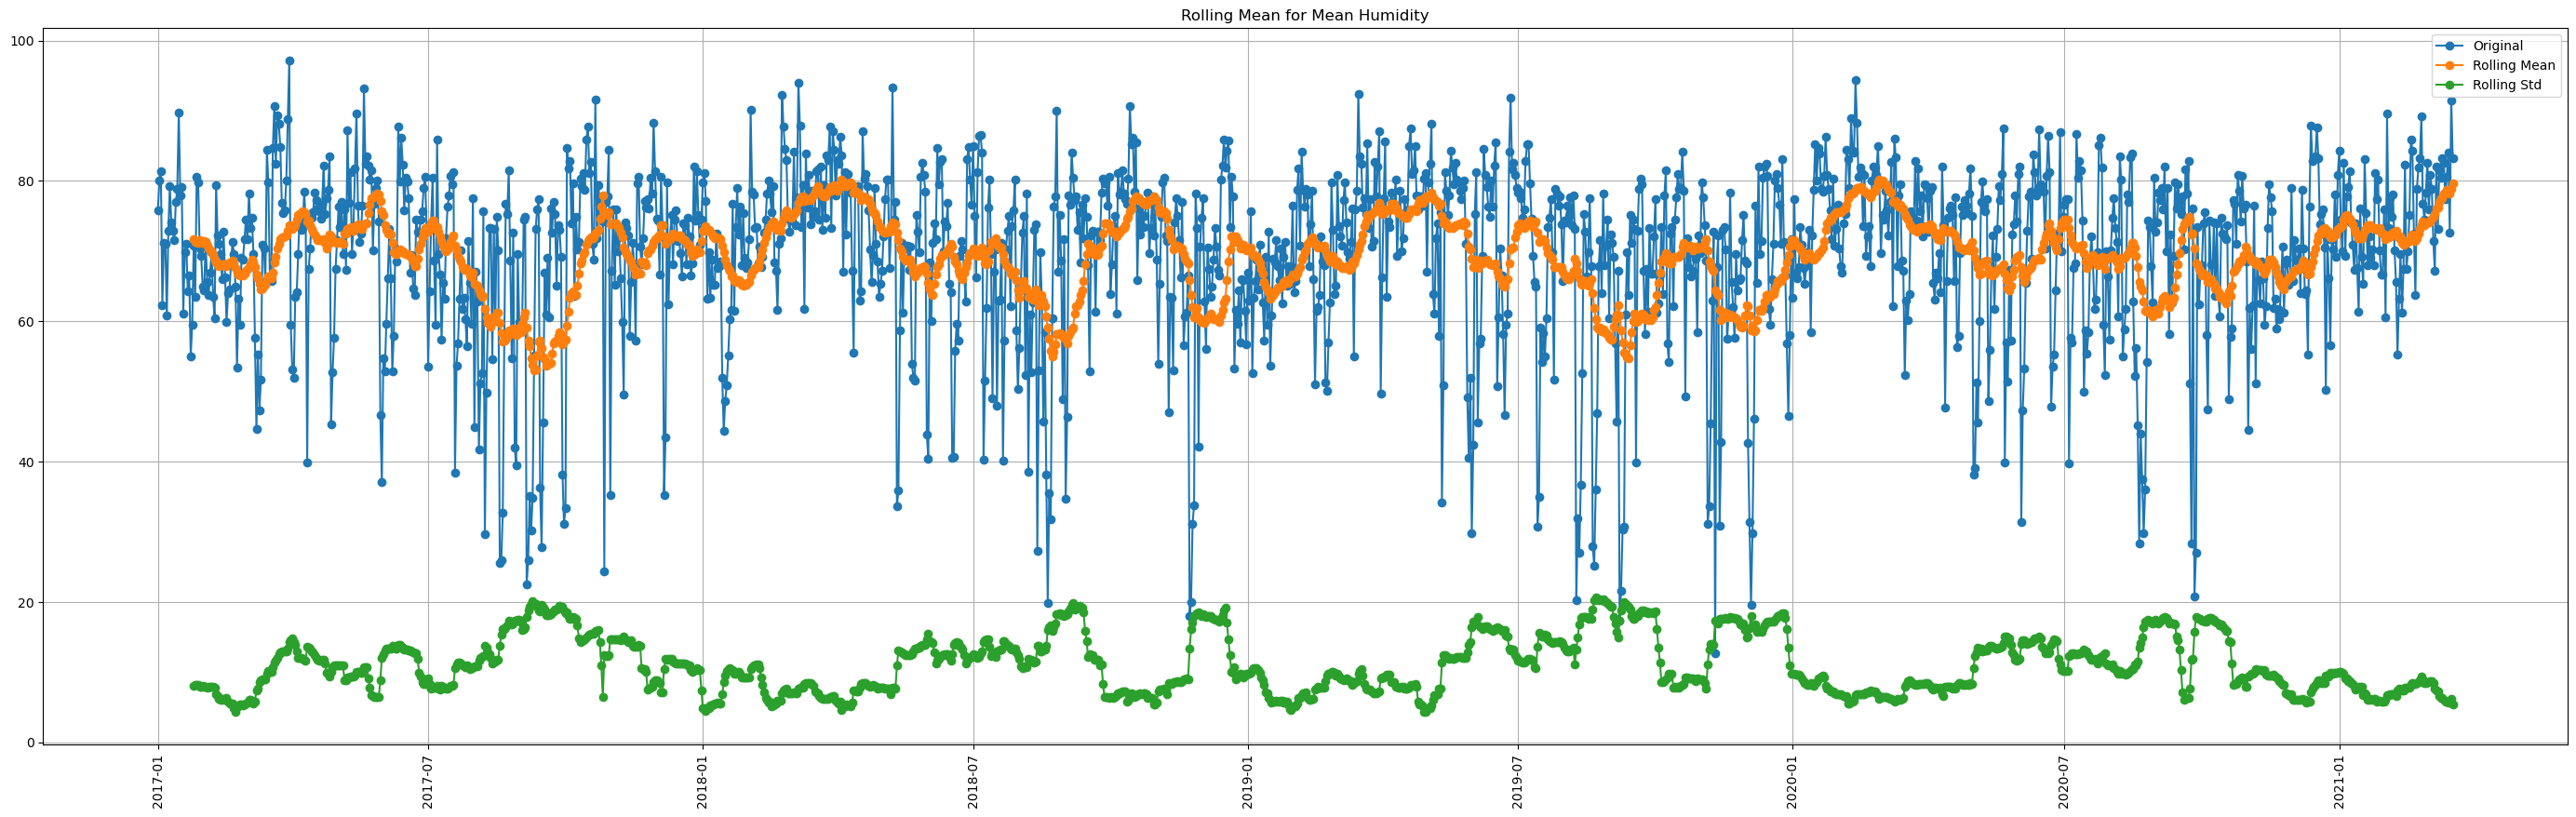

In [34]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['RH'], marker='o', label='Original')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['RH'].rolling(window=25).mean(), marker='o', label='Rolling Mean')
plt.plot(QLD_DATA['DATETIME'], QLD_DATA['RH'].rolling(window=25).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.title("Rolling Mean for Mean Humidity")
plt.legend()
plt.show()

In [223]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [224]:
for name, column in QLD_DATA.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TOTALDEMAND" 
    -----------------------------------------------
ADF Statistic: -3.705358
p-value: 0.004038
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "TEMPERATURE" 
    -----------------------------------------------
ADF Statistic: -2.247884
p-value: 0.189327
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Non-stationary


    Augmented Dickey-Fuller Test on "Rain" 
    -----------------------------------------------
ADF Statistic: -12.221749
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "Evap" 
    -----------------------------------------------
ADF Statistic: -3.759932
p-value: 0.003345
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "Radn" 
    -----------------------------------------------
ADF Statistic: -2.964348
p-value: 0.038361
Critical Values:
	

In [225]:
for name, column in QLD_DATA.diff().dropna().items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TOTALDEMAND" 
    -----------------------------------------------
ADF Statistic: -9.622724
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "TEMPERATURE" 
    -----------------------------------------------
ADF Statistic: -15.600890
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "Rain" 
    -----------------------------------------------
ADF Statistic: -15.128678
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "Evap" 
    -----------------------------------------------
ADF Statistic: -13.465125
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
Stationary


    Augmented Dickey-Fuller Test on "Radn" 
    -----------------------------------------------
ADF Statistic: -15.640099
p-value: 0.000000
Critical Values:
	1

In [29]:
m = 1
s = -m*7
e = -(m-1)*7
QLD = QLD_DATA.drop(['Evap','bushfire','flood', 'temp_change'],axis=1)
QLD_CLIMATE_ONLY = QLD_DATA.drop(['Evap','bushfire', 'flood', 'temp_change', 'humid_change', 'rain_change', 'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],axis=1)

train = QLD[:s]
test = QLD[s:]
print(train.head())
print(test.head())

y_train = train['TOTALDEMAND']
y_test = test['TOTALDEMAND']

            TOTALDEMAND  TEMPERATURE  Rain  Radn    VP     RH  humid_change  \
DATETIME                                                                      
2010-01-01      5760.08        25.02   0.0  20.3  23.1  69.75          0.00   
2010-01-02      5965.03        26.35   0.2  24.6  23.8  70.15          0.40   
2010-01-03      6026.73        25.46   0.0  13.1  27.6  78.25          8.10   
2010-01-04      6305.92        24.60  10.4  11.3  23.2  72.10         -6.15   
2010-01-05      6266.62        23.87   0.0  15.5  22.4  75.00          2.90   

            rain_change  high_humid_past_week  high_rain_past_week  \
DATETIME                                                             
2010-01-01          0.0                     0                    0   
2010-01-02          0.2                     0                    0   
2010-01-03         -0.2                     0                    0   
2010-01-04         10.4                     0                    0   
2010-01-05        -10.4   

In [30]:
model_7_window_cli = pmd.auto_arima(
    y_train,
    train.drop(['TOTALDEMAND'],axis=1),
    m=7,
    seasonal=True,
    start_p=6,
    max_p=8,
    start_P=0,
    d=1,
    #D=1,
    start_q=2,
    max_q=19, 
    start_Q=1,
    max_Q=20,
    max_order=30, 
    test='adf',
    error_action='ignore',  
    suppress_warnings=True,
    stepwise=True, 
    trace=True
)

Performing stepwise search to minimize aic


 ARIMA(6,1,2)(0,0,1)[7] intercept   : AIC=54547.136, Time=19.85 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=57431.779, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=54687.333, Time=10.99 sec


In [26]:
model_7_window_cli.params()

intercept        0.268428
ar.L1           -0.963043
ar.L2           -0.960861
ar.L3           -0.895439
ar.L4           -0.873122
ar.L5           -0.897446
ar.L6           -0.885390
ma.L1            0.846003
ma.L2            0.359865
ma.S.L7         -0.594799
ma.S.L14         0.088683
ma.S.L21         0.004796
sigma2       47507.968071
dtype: float64

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                 4088
Model:             SARIMAX(6, 1, 2)x(0, 0, [1, 2, 3], 7)   Log Likelihood              -27328.605
Date:                                   Sat, 05 Oct 2024   AIC                          54683.210
Time:                                           18:27:15   BIC                          54765.312
Sample:                                       01-01-2010   HQIC                         54712.281
                                            - 03-11-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2684      4.420      0.061      0.952    

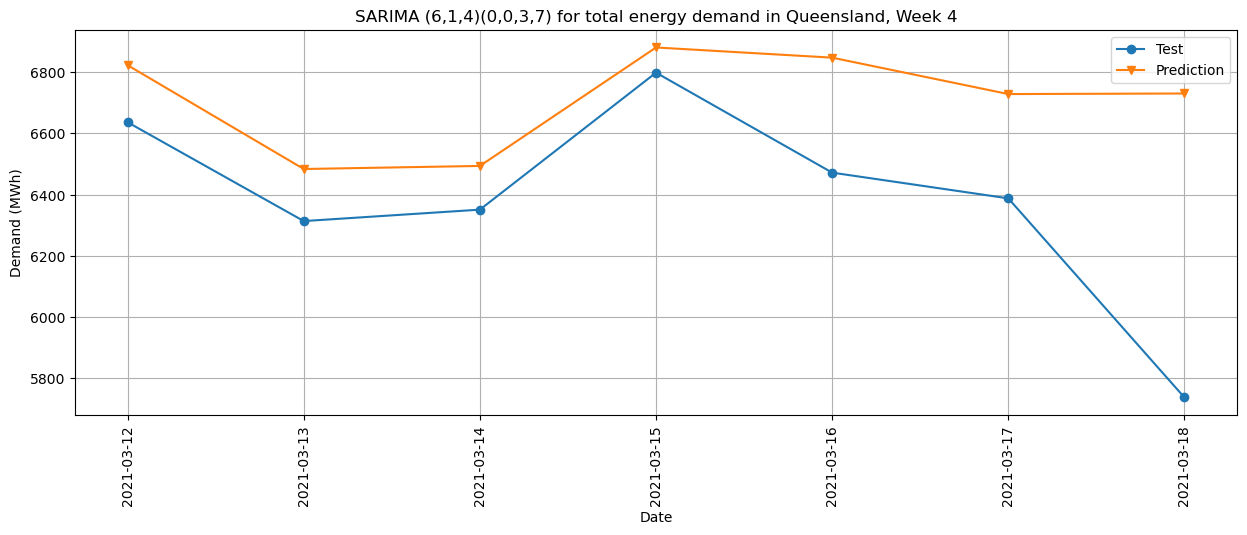

Mean Absolute Percentage Error 0.05347794307821322
Mean Squared Error 190861.01920890523
RMSE 436.87643471456005
AIC values 54683.20968257106


,Test,Prediction,Difference,% Change
0,6636.76,6823.271832,-186.511832,2.810284
1,6313.69,6483.912783,-170.222783,2.696090
2,6351.05,6493.942851,-142.892851,2.249909
3,6798.86,6881.216669,-82.356669,1.211331
4,6472.06,6847.933238,-375.873238,5.807629
5,6387.94,6728.916976,-340.976976,5.337824
6,5737.03,6730.769251,-993.739251,17.321493


In [28]:
model = model_7_window_cli
print(model.summary())
print(model.params)



pred=model.predict(n_periods=7, X=test.drop(columns=['TOTALDEMAND'])[s:], alpha=0.05)
#pred = base_prediction[-108:]

plt.figure(figsize=(15,5))
plt.grid()
plt.title("SARIMA (6,1,4)(0,0,3,7) for total energy demand in Queensland, Week 4")
plt.ylabel("Demand (MWh)")
plt.xlabel("Date")
#plt.plot(test['DATETIME'],y_test, marker='o', label='Test')
#plt.plot(test['DATETIME'],pred, marker='v', label='Prediction')

plt.plot(test.index[s:],y_test[s:], marker='o', label='Test')
plt.plot(test.index[s:],pred, marker='v', label='Prediction')

plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(y_test[s:], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(test['TOTALDEMAND'][s:], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("AIC values {}".format(model.aic()))
print("="*50)
print("="*50)
print("="*50)
print("="*50)


a=pd.DataFrame(y_test[s:])
a=a.reset_index()
a=a.drop(columns='DATETIME')
a

prediction=pd.DataFrame(pred)
prediction=prediction.reset_index()
#prediction=prediction.drop(columns='DATETIME')
prediction=prediction.drop(columns='index')
prediction
output=pd.DataFrame()
output['Test']=a['TOTALDEMAND']
#output['Prediction']=prediction['FORECASTDEMAND']
output['Prediction']=prediction[0]
output['Difference']=output['Test']-output['Prediction']
output['% Change']=abs(output['Difference']/output['Test'])*100
output

In [1]:
test[s:]

NameError: name 'test' is not defined

In [370]:
test

,TOTALDEMAND,TEMPERATURE,Rain,Radn,VP,RH,humid_change,rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
DATETIME,,,,,,,,,,,
2021-03-12,6636.76,23.15,2.8,19.8,23.7,82.65,-0.55,2.2,1,1,1
2021-03-13,6313.69,23.92,0.0,20.3,23.7,77.40,-5.25,-2.8,1,1,1
2021-03-14,6351.05,25.19,0.0,24.2,24.6,80.55,3.15,0.0,1,1,1
2021-03-15,6798.86,21.27,2.6,4.8,23.8,84.00,3.45,2.6,0,1,1
2021-03-16,6472.06,20.39,6.8,8.3,18.8,72.65,-11.35,4.2,0,1,1
2021-03-17,6387.94,19.72,8.0,4.0,22.2,91.50,18.85,1.2,1,1,1
2021-03-18,5737.03,19.50,17.4,16.9,23.8,83.20,-8.30,9.4,1,1,1


In [197]:
week_1_all_variables = '''
==================================================
==================================================
Mean Absolute Percentage Error 0.04398770684340288
==================================================
Mean Squared Error 121566.10396113756
==================================================
RMSE 348.66331031689805
==================================================
AIC values 52826.85275246331
==================================================
==================================================
==================================================
==================================================
'''

In [ ]:
week_1_all_variables_evap = """
==================================================
==================================================
Mean Absolute Percentage Error 0.04677841683162258
==================================================
Mean Squared Error 136240.31966625885
==================================================
RMSE 369.10746357430764
==================================================
AIC values 52815.88294076553
==================================================
==================================================
==================================================
==================================================
"""

In [ ]:
week_2_fit = '''
==================================================
==================================================
Mean Absolute Percentage Error 0.043205840392508084
==================================================
Mean Squared Error 102872.44520802706
==================================================
RMSE 320.7373461385921
==================================================
AIC values 52908.60228917624
==================================================
==================================================
==================================================
==================================================
'''

In [ ]:
week2_no_rolling = """
==================================================
==================================================
Mean Absolute Percentage Error 0.039215841157271815
==================================================
Mean Squared Error 86327.70538885058
==================================================
RMSE 293.81576776757674
==================================================
AIC values 52967.58303298784
==================================================
==================================================
==================================================
==================================================
"""

In [ ]:
week_3_fit = '''
==================================================
==================================================
Mean Absolute Percentage Error 0.038080906272112865
==================================================
Mean Squared Error 75000.58373842014
==================================================
RMSE 273.8623445061773
==================================================
AIC values 53748.6546377503
==================================================
==================================================
==================================================
==================================================
'''

In [ ]:
week_3_no_rolling = '''
==================================================
==================================================
Mean Absolute Percentage Error 0.02118715030907647
==================================================
Mean Squared Error 21863.31604419562
==================================================
RMSE 147.86249032190557
==================================================
AIC values 53269.960526548355
==================================================
==================================================
==================================================
==================================================
'''

In [ ]:
week_4_rolling_fit = """
==================================================
==================================================
Mean Absolute Percentage Error 0.028631323064325514
==================================================
Mean Squared Error 86226.34036487978
==================================================
RMSE 293.64321951116085
==================================================
AIC values 53120.78661477174
==================================================
==================================================
==================================================
==================================================
"""

In [ ]:
week_4_no_rolling_fit = """
==================================================
==================================================
Mean Absolute Percentage Error 0.025985481001282985
==================================================
Mean Squared Error 79214.85569305536
==================================================
RMSE 281.45133805518736
==================================================
AIC values 53134.698820707345
==================================================
==================================================
==================================================
==================================================
"""

In [ ]:
Total_only ="""
==================================================
==================================================
Mean Absolute Percentage Error 0.05347794307821322
==================================================
Mean Squared Error 190861.01920890523
==================================================
RMSE 436.87643471456005
==================================================
AIC values 54683.20968257106
==================================================
==================================================
==================================================
==================================================
"""